In [2]:
%matplotlib inline
!pip install backtrader[plotting]

When accessing the values in a line, the current value is accessed with index: 0

And the “last” output value is accessed with -1

The easiest and simplest way to access the current value of this moving average:

*self.sma = SimpleMovingAverage(.....)*

*av = self.sma[0]*

***Basic Setup :***

---



A line is a succession of points that when joined together form this line. When talking about the markets, a Data Feed has usually the following set of points per day:

    Open, High, Low, Close, Volume, OpenInterest

The series of “Open”s along time is a Line. And therefore a Data Feed has usually 6 lines.

In [3]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt
%matplotlib inline

if __name__ == '__main__':
    cerebro = bt.Cerebro()

    print ('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.run()

    print ('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.00


Above, the Cerebro engine has created a broker instance in the background. The instance already has some cash to start with. Below we will change the starting portfolio value


In [4]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(100000.0)

    print ('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.run()

    print ('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


***Adding a Data Feed :***

In [5]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects

# Import the backtrader platform
import backtrader as bt

if __name__ == '__main__':
    # Create a cerebro entity   
    cerebro = bt.Cerebro()

    # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname="AAPL",
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


***Our First Strategy -***

Let’s put a Strategy into the equation and print the “Close” price of each day (bar).

DataSeries (the underlying class in Data Feeds) objects have aliases to access the well known OHLC (Open High Low Close) daily values. This should ease up the creation of our printing logic.

In [6]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import datetime
import backtrader as bt

# Create a Strategy
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)

    data = bt.feeds.YahooFinanceData(
        dataname="AAPL",
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)
    
    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2000-01-03, Close, 0.86
2000-01-04, Close, 0.79
2000-01-05, Close, 0.80
2000-01-06, Close, 0.73
2000-01-07, Close, 0.77
2000-01-10, Close, 0.75
2000-01-11, Close, 0.72
2000-01-12, Close, 0.67
2000-01-13, Close, 0.75
2000-01-14, Close, 0.77
2000-01-18, Close, 0.80
2000-01-19, Close, 0.82
2000-01-20, Close, 0.88
2000-01-21, Close, 0.86
2000-01-24, Close, 0.82
2000-01-25, Close, 0.87
2000-01-26, Close, 0.85
2000-01-27, Close, 0.85
2000-01-28, Close, 0.78
2000-01-31, Close, 0.80
2000-02-01, Close, 0.77
2000-02-02, Close, 0.76
2000-02-03, Close, 0.80
2000-02-04, Close, 0.83
2000-02-07, Close, 0.88
2000-02-08, Close, 0.89
2000-02-09, Close, 0.87
2000-02-10, Close, 0.88
2000-02-11, Close, 0.84
2000-02-14, Close, 0.89
2000-02-15, Close, 0.92
2000-02-16, Close, 0.88
2000-02-17, Close, 0.89
2000-02-18, Close, 0.86
2000-02-22, Close, 0.88
2000-02-23, Close, 0.90
2000-02-24, Close, 0.89
2000-02-25, Close, 0.85
2000-02-28, Close, 0.87
2000-02-29, Close, 0.88
2000

***IMP -***

1. The first data in the list *self.datas[0]* is the default data for trading operations and to keep all strategy elements synchronized (it’s the system clock)

2. *self.dataclose = self.datas[0].close* keeps a reference to the close line.

***Adding some Logic to the Strategy -***

If the price has been falling 3 sessions in a row … BUY BUY BUY!!!


In [7]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import datetime
import backtrader as bt

# Create a Strategy
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        #current close less than previous one
        if self.dataclose[0] < self.dataclose[-1]:
            if self.dataclose[-1] < self.dataclose[-2]:
                #place buy order
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)

    data = bt.feeds.YahooFinanceData(
        dataname="AAPL",
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)
    
    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2000-01-03, Close, 0.86
2000-01-04, Close, 0.79
2000-01-05, Close, 0.80
2000-01-06, Close, 0.73
2000-01-07, Close, 0.77
2000-01-10, Close, 0.75
2000-01-11, Close, 0.72
2000-01-11, BUY CREATE, 0.72
2000-01-12, Close, 0.67
2000-01-12, BUY CREATE, 0.67
2000-01-13, Close, 0.75
2000-01-14, Close, 0.77
2000-01-18, Close, 0.80
2000-01-19, Close, 0.82
2000-01-20, Close, 0.88
2000-01-21, Close, 0.86
2000-01-24, Close, 0.82
2000-01-24, BUY CREATE, 0.82
2000-01-25, Close, 0.87
2000-01-26, Close, 0.85
2000-01-27, Close, 0.85
2000-01-28, Close, 0.78
2000-01-31, Close, 0.80
2000-02-01, Close, 0.77
2000-02-02, Close, 0.76
2000-02-02, BUY CREATE, 0.76
2000-02-03, Close, 0.80
2000-02-04, Close, 0.83
2000-02-07, Close, 0.88
2000-02-08, Close, 0.89
2000-02-09, Close, 0.87
2000-02-10, Close, 0.88
2000-02-11, Close, 0.84
2000-02-14, Close, 0.89
2000-02-15, Close, 0.92
2000-02-16, Close, 0.88
2000-02-17, Close, 0.89
2000-02-18, Close, 0.86
2000-02-22, Close, 0.88
2000-02-

Several “BUY” creation orders were issued, our porftolio value was decremented. A couple of important things are clearly missing.
The order was created but it is unknown if it was executed, when and at what price.



After knowing how to enter the market (long), an “exit concept” is needed and also understanding whether the strategy is in the market.

    Luckily a Strategy object offers access to a position attribute for the default data feed

    Methods buy and sell return the created (not yet executed) order

    Changes in orders’ status will be notified to the strategy via a notify method

The “exit concept” will be an easy one ( https://www.investopedia.com/terms/b/bar.asp ):

    Exit after 5 bars (on the 6th bar) have elapsed for good or for worse

    Please notice that there is no “time” or “timeframe” implied: number of bars. The bars can represent 1 minute, 1 hour, 1 day, 1 week or any other time period.

The next method gets no “bar index” passed and therefore it seems obscure how to understand when 5 bars may have elapsed, but this has been modeled in pythonic way: call len on an object and it will tell you the length of its lines. Just write down (save in a variable) at which length in an operation took place and see if the current length is 5 bars away.

In [8]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import datetime
import backtrader as bt


# Create a Strategy
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        #keeps track of pending order
        self.order = None
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            #Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

    # Check if an order has been completed, broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
            
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Cancelled/Margin/Rejected')

        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        #check if an order is pending. We cant send a second one if it is
        if self.order:
            return

        #check if we are in market
        if not self.position:
            #current close less than previous one
            if self.dataclose[0] < self.dataclose[-1]:
                if self.dataclose[-1] < self.dataclose[-2]:

                    #place buy order
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    #Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

        else:
            #already in market so we might sell
            if len(self) >= (self.bar_executed + 5):
                #SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)

    data = bt.feeds.YahooFinanceData(
        dataname="AAPL",
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)
    
    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2000-01-03, Close, 0.86
2000-01-04, Close, 0.79
2000-01-05, Close, 0.80
2000-01-06, Close, 0.73
2000-01-07, Close, 0.77
2000-01-10, Close, 0.75
2000-01-11, Close, 0.72
2000-01-11, BUY CREATE, 0.72
2000-01-12, BUY EXECUTED, 0.73
2000-01-12, Close, 0.67
2000-01-13, Close, 0.75
2000-01-14, Close, 0.77
2000-01-18, Close, 0.80
2000-01-19, Close, 0.82
2000-01-20, Close, 0.88
2000-01-20, SELL CREATE, 0.88
2000-01-21, SELL EXECUTED, 0.88
2000-01-21, Close, 0.86
2000-01-24, Close, 0.82
2000-01-24, BUY CREATE, 0.82
2000-01-25, BUY EXECUTED, 0.81
2000-01-25, Close, 0.87
2000-01-26, Close, 0.85
2000-01-27, Close, 0.85
2000-01-28, Close, 0.78
2000-01-31, Close, 0.80
2000-02-01, Close, 0.77
2000-02-01, SELL CREATE, 0.77
2000-02-02, SELL EXECUTED, 0.78
2000-02-02, Close, 0.76
2000-02-02, BUY CREATE, 0.76
2000-02-03, BUY EXECUTED, 0.77
2000-02-03, Close, 0.80
2000-02-04, Close, 0.83
2000-02-07, Close, 0.88
2000-02-08, Close, 0.89
2000-02-09, Close, 0.87
2000-02-10, 

***Adding broker commission costs -***

In [9]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import datetime
import backtrader as bt


# Create a Strategy
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        '''Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        #keeps track of pending order
        self.order = None
        self.buyprice = None
        self.buycomm = None
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            #Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

    # Check if an order has been completed, broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm: %.2f' % (order.executed.price, order.executed.value,
                     order.executed.comm))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm: %.2f' % (order.executed.price, order.executed.value,
                     order.executed.comm))
            
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Cancelled/Margin/Rejected')

        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        #check if an order is pending. We cant send a second one if it is
        if self.order:
            return

        #check if we are in market
        if not self.position:
            #current close less than previous one
            if self.dataclose[0] < self.dataclose[-1]:
                if self.dataclose[-1] < self.dataclose[-2]:

                    #place buy order
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    #Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

        else:
            #already in market so we might sell
            if len(self) >= (self.bar_executed + 5):
                #SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)

    data = bt.feeds.YahooFinanceData(
        dataname="AAPL",
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)
    
    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)
    # 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2000-01-03, Close, 0.86
2000-01-04, Close, 0.79
2000-01-05, Close, 0.80
2000-01-06, Close, 0.73
2000-01-07, Close, 0.77
2000-01-10, Close, 0.75
2000-01-11, Close, 0.72
2000-01-11, BUY CREATE, 0.72
2000-01-12, BUY EXECUTED, Price: 0.73, Cost: 0.73, Comm: 0.00
2000-01-12, Close, 0.67
2000-01-13, Close, 0.75
2000-01-14, Close, 0.77
2000-01-18, Close, 0.80
2000-01-19, Close, 0.82
2000-01-20, Close, 0.88
2000-01-20, SELL CREATE, 0.88
2000-01-21, SELL EXECUTED, Price: 0.88, Cost: 0.73, Comm: 0.00
2000-01-21, OPERATION PROFIT, GROSS 0.15, NET 0.15
2000-01-21, Close, 0.86
2000-01-24, Close, 0.82
2000-01-24, BUY CREATE, 0.82
2000-01-25, BUY EXECUTED, Price: 0.81, Cost: 0.81, Comm: 0.00
2000-01-25, Close, 0.87
2000-01-26, Close, 0.85
2000-01-27, Close, 0.85
2000-01-28, Close, 0.78
2000-01-31, Close, 0.80
2000-02-01, Close, 0.77
2000-02-01, SELL CREATE, 0.77
2000-02-02, SELL EXECUTED, Price: 0.78, Cost: 0.81, Comm: 0.00
2000-02-02, OPERATION PROFIT, GROSS -0.03

Unfortunately (or fortunately to better understand the platform) there is an open position on the last day of the Data Feed. Even if a SELL operation has been sent … IT HAS NOT YET BEEN EXECUTED

***Customizing the Strategy: Parameters -***

It would a bit unpractical to hardcode some of the values in the strategy and have no chance to change them easily. Parameters come in handy to help.



In [10]:
# params = (
#     ('myparams', 27), 
#     ('exitbars', 5),
# )
# cerebro.addstrategy(TestStrategy, myparam = 20, exitbars = 7)

***Adding an indicator -***

Inspired in one of the examples from PyAlgoTrade a strategy using a Simple Moving Average.

    Buy “AtMarket” if the close is greater than the Average

    If in the market, sell if the close is smaller than the Average

    Only 1 active operation is allowed in the market

Most of the existing code can be kept in place. Let’s add the average during init and keep a reference to it:

In [11]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname="AAPL",
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 1000.00
2000-01-24, Close, 0.82
2000-01-24, BUY CREATE, 0.82
2000-01-25, BUY EXECUTED, Price: 0.81, Cost: 8.10, Comm 0.00
2000-01-25, Close, 0.87
2000-01-26, Close, 0.85
2000-01-27, Close, 0.85
2000-01-28, Close, 0.78
2000-01-28, SELL CREATE, 0.78
2000-01-31, SELL EXECUTED, Price: 0.78, Cost: 8.10, Comm 0.00
2000-01-31, OPERATION PROFIT, GROSS -0.30, NET -0.30
2000-01-31, Close, 0.80
2000-01-31, BUY CREATE, 0.80
2000-02-01, BUY EXECUTED, Price: 0.80, Cost: 8.00, Comm 0.00
2000-02-01, Close, 0.77
2000-02-01, SELL CREATE, 0.77
2000-02-02, SELL EXECUTED, Price: 0.78, Cost: 8.00, Comm 0.00
2000-02-02, OPERATION PROFIT, GROSS -0.20, NET -0.20
2000-02-02, Close, 0.76
2000-02-03, Close, 0.80
2000-02-04, Close, 0.83
2000-02-04, BUY CREATE, 0.83
2000-02-07, BUY EXECUTED, Price: 0.83, Cost: 8.30, Comm 0.00
2000-02-07, Close, 0.88
2000-02-08, Close, 0.89
2000-02-09, Close, 0.87
2000-02-10, Close, 0.88
2000-02-11, Close, 0.84
2000-02-14, Close, 0.89
2000-02-15, Close, 0.9

First date which is shown in the log : It’ no longer 2000-01-03, the first trading day in the year 2K. The missing days are not missing. The platform has adapted to the new circumstances:

    An indicator (SimpleMovingAverage) has been added to the Strategy.

    This indicator needs X bars to produce an output: in the example: 15

    2000-01-24 is the day in which the 15th bar occurs

The missing days are not missing. The platform has adapted to the new circumstances:

    An indicator (SimpleMovingAverage) has been added to the Strategy.

    This indicator needs X bars to produce an output: in the example: 15

    2000-01-24 is the day in which the 15th bar occurs


***Visual Inspection: Plotting -***

In order to display the automatic plotting capabilities and a couple of easy customizations, the following will be done:

    A 2nd MovingAverage (Exponential) will be added. The defaults will plot it (just like the 1st) with the data.

    A 3rd MovingAverage (Weighted) will be added. Customized to plot in an own plot (even if not sensible)

    A Stochastic (Slow) will be added. No change to the defaults.

    A MACD will be added. No change to the defaults.

    A RSI will be added. No change to the defaults.

    A MovingAverage (Simple) will be applied to the RSI. No change to the defaults (it will be plotted with the RSI)

    An AverageTrueRange will be added. Changed defaults to avoid it being plotted.


Starting Portfolio Value: 1000.00
2000-02-18, Close, 0.86
2000-02-18, BUY CREATE, 0.86
2000-02-22, BUY EXECUTED, Price: 0.85, Cost: 8.50, Comm 0.00
2000-02-22, Close, 0.88
2000-02-23, Close, 0.90
2000-02-24, Close, 0.89
2000-02-25, Close, 0.85
2000-02-25, SELL CREATE, 0.85
2000-02-28, SELL EXECUTED, Price: 0.85, Cost: 8.50, Comm 0.00
2000-02-28, OPERATION PROFIT, GROSS 0.00, NET 0.00
2000-02-28, Close, 0.87
2000-02-29, Close, 0.88
2000-02-29, BUY CREATE, 0.88
2000-03-01, BUY EXECUTED, Price: 0.91, Cost: 9.10, Comm 0.00
2000-03-01, Close, 1.01
2000-03-02, Close, 0.94
2000-03-03, Close, 0.99
2000-03-06, Close, 0.97
2000-03-07, Close, 0.95
2000-03-08, Close, 0.94
2000-03-09, Close, 0.94
2000-03-10, Close, 0.97
2000-03-13, Close, 0.94
2000-03-14, Close, 0.88
2000-03-14, SELL CREATE, 0.88
2000-03-15, SELL EXECUTED, Price: 0.89, Cost: 9.10, Comm 0.00
2000-03-15, OPERATION PROFIT, GROSS -0.20, NET -0.20
2000-03-15, Close, 0.90
2000-03-16, Close, 0.94
2000-03-16, BUY CREATE, 0.94
2000-03-17, B

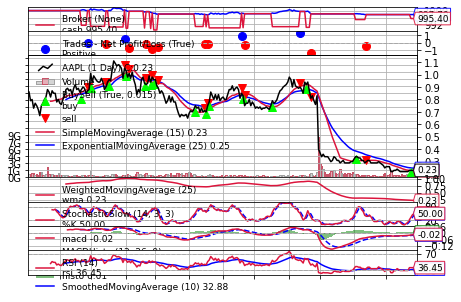

In [13]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import matplotlib.pyplot as plt
import datetime  # For datetime objects

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname="AAPL",
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot(iplot = False)

The final result has changed even if the logic hasn’t. This is true but the logic has not been applied to the same number of bars

***Let’s Optimize -***

Before the plotting sample, when the strategy started using an indicator the period default value was 15 bars. It’s a strategy parameter and this can be used in an optimization to change the value of the parameter and see which one better fits the market.The sample is modified to optimize the period of the Simple Moving Average. For the sake of clarity any output with regards to Buy/Sell orders has been removed

In [14]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])


# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        maperiod=range(10, 31))

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname="AAPL",
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Run over everything
    cerebro.run(maxcpus=1)

2000-12-29, (MA Period 10) Ending Value 998.90
2000-12-29, (MA Period 11) Ending Value 999.10
2000-12-29, (MA Period 12) Ending Value 998.10
2000-12-29, (MA Period 13) Ending Value 998.20
2000-12-29, (MA Period 14) Ending Value 998.30
2000-12-29, (MA Period 15) Ending Value 997.40
2000-12-29, (MA Period 16) Ending Value 997.20
2000-12-29, (MA Period 17) Ending Value 997.10
2000-12-29, (MA Period 18) Ending Value 997.20
2000-12-29, (MA Period 19) Ending Value 997.30
2000-12-29, (MA Period 20) Ending Value 996.70
2000-12-29, (MA Period 21) Ending Value 996.50
2000-12-29, (MA Period 22) Ending Value 996.90
2000-12-29, (MA Period 23) Ending Value 997.30
2000-12-29, (MA Period 24) Ending Value 996.80
2000-12-29, (MA Period 25) Ending Value 996.90
2000-12-29, (MA Period 26) Ending Value 996.90
2000-12-29, (MA Period 27) Ending Value 998.60
2000-12-29, (MA Period 28) Ending Value 998.70
2000-12-29, (MA Period 29) Ending Value 999.90
2000-12-29, (MA Period 30) Ending Value 999.40


Instead of calling addstrategy to add a stratey class to Cerebro, the call is made to ***optstrategy***. And instead of passing a value a range of values is passed.

Results:

    For periods below 18 the strategy (commissionless) loses money.

    For periods between 18 and 26 (both included) the strategy makes money.

    Above 26 money is lost again.
